In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 40)

In [7]:
# Collecte des données

data = pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])

Dans ce NoteBook, nous allons déterminer en fonction des données de la base de l'ADEME, les probabilités pour chaque type de véhicule (i.e en fonction du carburant et du Crit'Air) de tomber en panne avec l'âge. Ces "fonctions de panne" nous serviront à modéliser l'évolution du parc par la suite.

Pour rappel, nous nous focalisons sur les véhicules particuliers. De plus, le volet "modélisation" se concentre sur les combinaisons carburant-Crit'Air possibles (par exemple il n'existe pas de véhicule essence Crit'Air 5), nous ne considérerons donc que celles-ci (regroupées dans le tableau ```possibles```), en ne prenant pas en compte les carburants "HNR" (hybrides non-rechargeables) qui sont très minoritaires.

In [8]:
# On créé le tableau possibles

possibles = []

for i in ["Crit'Air 2", "Crit'Air 3", "Crit'Air 4", "Crit'Air 5"] :
    possibles.append(("Diesel", i))
for i in ["Crit'Air 1", "Crit'Air 2", "Crit'Air 3"] :
    possibles.append(("Essence", i))
    
possibles.append(("Hybride rechargeable", "Crit'Air 1"))
possibles.append(('Electrique et hydrogène', "Crit'Air E"))

In [9]:
# On créé le Data Frame avec le nombre de véhicules par années, sans distinction de région

# On se focalise sur les véhicules particuliers
df = data.loc[(data["CATEGORIE_VEHICULE"] == "Véhicule particulier")]

def age_num(age) :
    res = []
    for i in range (len(age)) :
        res.append(int(str(age[i])[0:2]))
    return res

# On créé une colonne avec l'âge du véhicule sous forme numérique
df.insert(loc = 1, column = 'AGE_NUM', value = age_num(np.array(df['AGE'], dtype = str)))

# On peut se séparer de certaines colonnes
df = df.drop(['CATEGORIE_VEHICULE', 'REGION_CODE', 'REGION_LIBELLE', 'CLASSE_VEHICULE', 'STATUT_UTILISATEUR', 'AGE'], axis = 1)

# On effectue la somme pour les différentes régions et statuts d'utilisateurs
df = df.groupby(['CARBURANT','CRITAIR', 'AGE_NUM'], as_index = False).sum()

def final_age(age) :
    res = []
    for i in range (len(age) - 1) :
        if age[i] < age[i+1] :
            res.append(0)
        else : 
            res.append(1)
    res.append(1)
    return res

# La colonne "FINAL_AGE", binaire, donne l'information sur la présence ou non de véhicules du même type
# mais plus agés dans le DataFrame, elle nous sert à connaître les frontières entre chaque type de véhicule

df.insert(loc = 2, column = 'FINAL_AGE', value = final_age(np.array(df['AGE_NUM'], dtype = int)))

df = df.groupby(['CARBURANT','CRITAIR', 'AGE_NUM']).sum()
df = df.sort_values(by = ['CARBURANT','CRITAIR', 'AGE_NUM'])

df.head(10)

FINAL_AGE  PARC_2011  PARC_2012  PARC_2013  \
CARBURANT CRITAIR    AGE_NUM                                               
Diesel    Crit'Air 1 0                0          0          4          8   
                     1                0          0          0          5   
                     2                0          0          0          0   
                     3                0          1          0          0   
                     4                0          0          1          0   
                     5                0          0          0          1   
                     6                0          1          0          0   
                     7                0          0          1          0   
                     8                0          0          0          1   
                     9                0          0          0          0   

                              PARC_2014  PARC_2015  PARC_2016  PARC_2017  \
CARBURANT CRITAIR    AGE_NUM                                               
Diesel    Crit'Air 1 0               11          4          6          2   
                     1               10         10          3          5   
                     2                4          9          7          1   
                     3                0          3          8          5   
                     4                0          0          2          6   
                     5                0          0          0          1   
                     6                1          0          0          0   
                     7                0          0          0          0   
                     8                0          0          0          0   
                     9                1          0          0          0   

                              PARC_2018  PARC_2019  PARC_2020  PARC_2021  \
CARBURANT CRITAIR    AGE_NUM                                               
Diesel    Crit'Air 1 0                1          2          2          0   
                     1                2          1          1          1   
                     2                5          1          1          0   
                     3                0          2          1          1   
                     4                2          0          0          1   
                     5                5          2          0          0   
                     6                0          5          2          0   
                     7                0          0          5          2   
                     8                0          0          0          3   
                     9                0          0          0          0   

                              PARC_2022  
CARBURANT CRITAIR    AGE_NUM             
Diesel    Crit'Air 1 0                0  
                     1                0  
                     2                1  
                     3                0  
                     4                0  
                     5                0  
                     6                0  
                     7                0  
                     8                1  
                     9                0

In [10]:
# On détermine nos DataFrame sur les probabilités de panne

# df2 nous servira pour le nombre absolu de pannes, df3 pour les proportions
df2 = df - df.shift(periods = - 1, axis = 0).shift(periods = -1, axis = 1)
df3 = df2/df

# On enlève toutes les lignes qui sont à la frontières entre deux types de véhicules
index = df.loc[df['FINAL_AGE'] == 1].index.tolist()

df2 = df2.drop(index)
df2 = df2.drop(['FINAL_AGE', 'PARC_2022'], axis = 1)

df3 = df3.drop(index)
df3 = df3.drop(['FINAL_AGE', 'PARC_2022'], axis = 1)

# On enlève toutes les lignes avec des valeurs négatives ou nulles, pour que ces exceptions ne faussent pas
# les moyennes
df2 = (df2 + abs(df2))/2
df3 = (df3 + abs(df3))/2

# Pour que les 0 ne soient pas comptabilisés dans les moyennes, on les remplacent temporairement pas des NaN
df2.replace(0, np.nan, inplace = True)
df3.replace(0, np.nan, inplace = True)

# On calcule les moyennes, en absolu et en proportion
pannes = df2.mean(axis = 1, skipna = True)
pannes_prop = df3.mean(axis = 1, skipna = True)

# On remplace les NaN utilisés en 0 pour que le DataFrame soit plus propre
df2.replace(np.nan, 0, inplace = True)
df3.replace(np.nan, 0, inplace = True)

In [19]:
pannes_prop = pd.DataFrame(pannes_prop)

# On définit la fonction permettant de visualiser les résultats, ainsi que la régression linéaire commencée à
# l'année start
def plot_wt_start(carb, crit, start) :
    l = (carb, crit)
    y = pannes_prop.loc[l]
    if len(y) > start + 1: 
        x = np.arange(0, len(y), 1)
        y_0 = pd.DataFrame(y[0][start:])
        idx = y_0.loc[y_0[0] < np.inf].index
        fit = np.polyfit(x[idx], y_0.loc[idx], 1)
        y_fit = fit[0]*x[idx] + fit[1]
        t = np.arange(0, len(y), 1)
        labl = p[1] + ", " + p[0]
        plt.scatter(t, y, label = labl)
        plt.plot(x[idx], y_fit, label = labl)

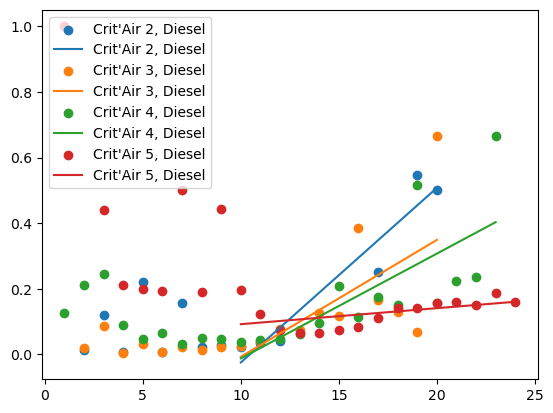

In [20]:
# On définit l'année de départ de la régression, avant celle-ci on considère que les véhicules ne tombent pas en 
# panne, ce qui constitue une hypothèse relativement faible pour la plupart des types de véhicules
start = 10

# On plot cela pour les véhicules diesels
for p in possibles[0:4] :
    plot_wt_start(p[0], p[1], 10)

plt.legend(loc="upper left")
plt.show()

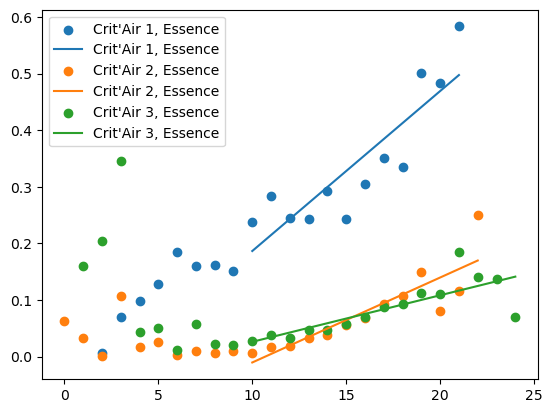

In [21]:
# Puis pour les véhicules essences
for p in possibles[4:7] :
    plot_wt_start(p[0], p[1], 10)

plt.legend(loc="upper left")
plt.show()

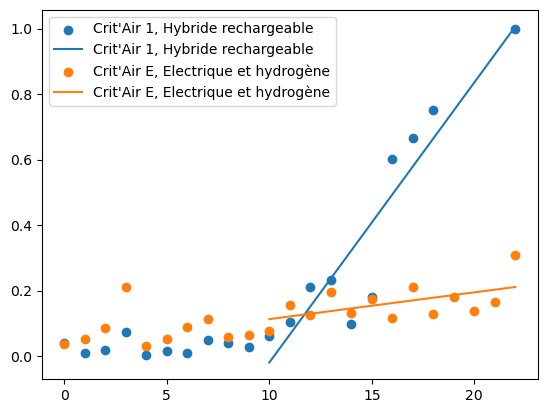

In [22]:
# Enfin pour les hybrides rechargeables et électriques
for p in possibles[7:] :
    plot_wt_start(p[0], p[1], 10)

plt.legend(loc="upper left")
plt.show()

In [23]:
# Création du DataFrame avec les résultats, qui va être exploité dans le NoteBook de modélisation

res = []
i = 0

for p in possibles :
    res.append([])
    l = (p[0], p[1])
    y = pannes_prop.loc[l]
    if len(y) > start + 1: 
        x = np.arange(0, 26, 1)
        y_0 = pd.DataFrame(y[0][start:])
        idx = y_0.loc[y_0[0] < np.inf].index
        fit = np.polyfit(x[idx], y_0.loc[idx], 1)
        y_fit = fit[0]*x[start:] + fit[1]

        res[i].extend([p[0], p[1]])
        res[i].extend(np.zeros(start))
        y_fit = np.maximum(y_fit, 0)
        y_fit = np.minimum(y_fit, 1)
        res[i].extend(y_fit)

        i += 1

columns = ['CARBURANT', 'CRITAIR']
columns.extend(np.arange(0,26))

res = pd.DataFrame(res, columns = columns)
res.head(8)

,CARBURANT,CRITAIR,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,Diesel,Crit'Air 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028349,0.081610,0.134870,0.188131,0.241391,0.294652,0.347912,0.401173,0.454433,0.507694,0.560954,0.614215,0.667475,0.720736,0.773996
1,Diesel,Crit'Air 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028139,0.063790,0.099442,0.135093,0.170744,0.206395,0.242046,0.277698,0.313349,0.349000,0.384651,0.420302,0.455953,0.491605,0.527256
2,Diesel,Crit'Air 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.019396,0.051376,0.083356,0.115335,0.147315,0.179294,0.211274,0.243254,0.275233,0.307213,0.339193,0.371172,0.403152,0.435131,0.467111
3,Diesel,Crit'Air 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091901,0.096785,0.101669,0.106553,0.111437,0.116322,0.121206,0.126090,0.130974,0.135858,0.140743,0.145627,0.150511,0.155395,0.160279,0.165163
4,Essence,Crit'Air 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.186575,0.214841,0.243107,0.271374,0.299640,0.327906,0.356172,0.384439,0.412705,0.440971,0.469237,0.497504,0.525770,0.554036,0.582302,0.610569
5,Essence,Crit'Air 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004635,0.019648,0.034661,0.049674,0.064688,0.079701,0.094714,0.109727,0.124740,0.139753,0.154766,0.169779,0.184792,0.199806,0.214819
6,Essence,Crit'Air 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026129,0.034354,0.042579,0.050805,0.059030,0.067256,0.075481,0.083706,0.091932,0.100157,0.108382,0.116608,0.124833,0.133058,0.141284,0.149509
7,Hybride rechargeable,Crit'Air 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.065702,0.151210,0.236717,0.322224,0.407732,0.493239,0.578747,0.664254,0.749762,0.835269,0.920777,1.000000,1.000000,1.000000,1.000000


On obtient le résultat souhaité : un tableau donnant pour chaque type de véhicule la probabilité empirique (obtenue par des moyennes sur les données de l'ADEME) de tomber en panne en fonction de son âge. Pour l'interpréter, il faut lire par exemple avec la première ligne : un véhicule diesel de Crit'Air 2 encore en fonctionnement à l'âge de 15 ans a 24,1% de chance de tomber en panne avant d'atteindre les 16 ans.

In [24]:
res.to_csv('fit_pannes.csv', index = False)